In [1]:
# load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor as KNR

In [2]:
# load the data
df = pd.read_csv('DOGE-USD-daily 2021.csv', index_col=0, header = 0)
close_price = pd.DataFrame({"Close": df["Close"]})
close_price

,Close
Date,
2021-01-01,0.005685
2021-01-02,0.010615
2021-01-03,0.009771
2021-01-04,0.009767
2021-01-05,0.009920
...,...
2022-07-16,0.064280
2022-07-17,0.063107
2022-07-18,0.067715


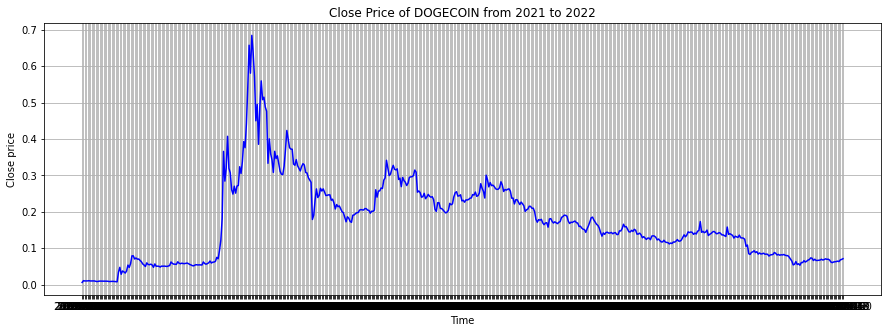

In [3]:
# Close Price of DOGECOIN from 2021 to 2022
plt.figure(figsize=(15,5))
plt.plot(close_price, linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Close price')
plt.title('Close Price of DOGECOIN from 2021 to 2022')
plt.grid(True)
plt.show()

In [4]:
# calculate MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# create lag variable
def create_lag(data, lag = 1):
    dataframe = pd.DataFrame()
    for i in range(lag, 0, -1):
        dataframe['t-' + str(i)] = data["Close"].shift(i)
    final_data = pd.concat([data, dataframe], axis=1)
    final_data.dropna(inplace=True)
    final_data.reset_index(inplace=True)
    return final_data

# split data
def split_data(final_data, test_length = 30):
    new_data = final_data.drop(['Date'], axis=1)
    new_data = new_data.reset_index(drop=True)
    end_point = len(new_data)
    x = end_point - test_length
    train = new_data.loc[:x - 1, :]
    test = new_data.loc[x:, :]
    test_x = test.loc[:, test.columns != 'Close']
    test_y = test['Close']
    train_x = train.loc[:, train.columns != 'Close']
    train_y = train['Close']
    return test_x, test_y, train_x, train_y

In [7]:
# initial data
final_data1 = create_lag(close_price, 1)
test_x1, test_y1, train_x1, train_y1 = split_data(final_data1)
# normalize data and tune the parameter to find best model
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train1 = sc_x.fit_transform(train_x1)
x_test1 = sc_x.transform(test_x1)
y_train1 = sc_y.fit_transform(np.array(train_y1).reshape(-1,1))
y_test1 = sc_y.transform(np.array(test_y1).reshape(-1,1))
# set n_neighbors=1
regressor1 = KNR(n_neighbors=1)
regressor1.fit(x_train1, y_train1)
y_pred1 = regressor1.predict(x_test1)
y_pred1

mean_error1 = mean_squared_error(y_test1,y_pred1)

y_prediction1 = sc_y.inverse_transform(np.array(y_pred1).reshape(-1,1))
y_prediction1 = y_prediction1.flatten()
mape_result1 = mape(test_y1, y_prediction1)

lag = 1
n_count = 1
min_mse = mean_error1
min_mape = mape_result1

for i in range (2, 51):
    for n in range(2,51):
        final_data = create_lag(close_price, i)
        test_x, test_y, train_x, train_y = split_data(final_data)

        sc_x = StandardScaler()
        sc_y = StandardScaler()
        x_train = sc_x.fit_transform(train_x)
        x_test = sc_x.transform(test_x)
        y_train = sc_y.fit_transform(np.array(train_y).reshape(-1,1))
        y_test = sc_y.transform(np.array(test_y).reshape(-1,1))

        regressor = KNR(n_neighbors=n)
        regressor.fit(x_train, y_train)
        y_pred = regressor.predict(x_test)

        mean_error = mean_squared_error(y_test,y_pred)

        y_prediction = sc_y.inverse_transform(np.array(y_pred).reshape(-1, 1))
        y_prediction = y_prediction.flatten()
        mape_result = mape(test_y, y_prediction)
        if mean_error < min_mse:
            min_mse = mean_error
            min_mape = mape_result
            lag = i
            n_count = n
# print the result
print("Lag is ", lag)
print("neighbors is ", n_count)
print("mean_sqrd_error is ", min_mse)
print("mape is ", min_mape)

Lag is  4
neighbors is  7
mean_sqrd_error is  0.0007406386304343968
mape is  3.5703664629135456


In [5]:
# the best model is when lag = 4, neighbor = 7
# split data
final_data = create_lag(close_price, 4)
test_x, test_y, train_x, train_y = split_data(final_data)
# transfer the data
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train = sc_x.fit_transform(train_x)
x_test = sc_x.transform(test_x)
y_train = sc_y.fit_transform(np.array(train_y).reshape(-1,1))
y_test = sc_y.transform(np.array(test_y).reshape(-1,1))
# predict
regressor = KNR(n_neighbors=7)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
# calculate mse
mean_error = mean_squared_error(y_test,y_pred)
# inverse the prediction
y_prediction = sc_y.inverse_transform(np.array(y_pred).reshape(-1,1))
y_prediction = y_prediction.flatten()
# calculate mape
mape_result = mape(test_y, y_prediction)
mse_post = mean_squared_error(test_y, y_prediction)

print("mse_post is ", mse_post )
print("mean_sqrd_error is ", mean_error)
print("mape is ", mape_result)
print("accuracy is ", 100-mape_result)

mse_post is  9.215537760544227e-06
mean_sqrd_error is  0.0007406386304343968
mape is  3.5703664629135456
accuracy is  96.42963353708646


In [10]:
from sklearn.metrics import r2_score
# Calculate the R-squared value
r_squared = r2_score(test_y, y_prediction)
print(f"R-squared: {r_squared}")

R-squared: 0.14906825676226154


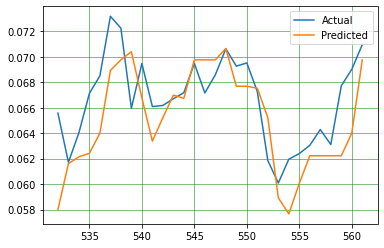

In [11]:
# plot the best model
df1 = pd.DataFrame({'Actual': test_y, 'Predicted': y_prediction})
df1.plot(kind='line')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()